In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
}))

source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [7]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

### Load guide df

In [9]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting


## FeaturePlot singlet & doublet

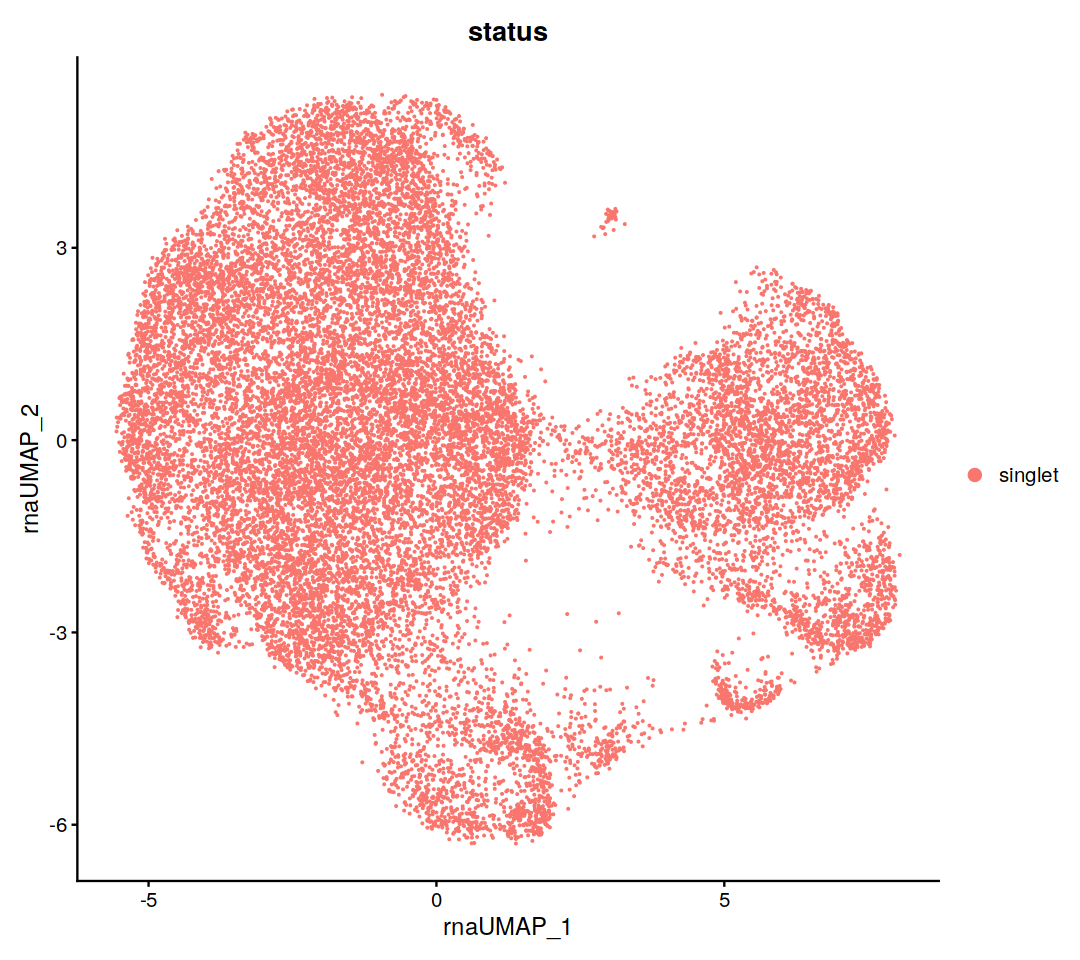

In [10]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 947

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [14]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

Guide+ = 20176 ; Guide- = 1188 


# Split by guide, then run DE testing 

In [15]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [16]:
targets = unique(filter(df_guide, class=='targeting')$alias)
df_de = NULL
genes_to_skip = c("CD55", "CSTB", "DE5")
#genes_to_skip = c()
guides_w_no_cells = c()

for(target in targets){
    if(target %in% genes_to_skip){
        cat(red("Skipping", target, "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target,":"), paste(guides_4_target, collapse=","),"\n")

    for(guide in guides_4_target) {
        seurat_dummy <- mark_guide_pos_target_neg(
            seurat_rna, 
            perturbed_cells_by_guide, 
            guide, 
            guides_4_target, 
            print_counts = T
        )
        
        if("guide_positive" %in% levels((Idents(seurat_dummy)))) {
            cat(blue("Found cells for ", guide, "\n"))
            markers <- FindMarkers(
                object = seurat_dummy,
                slot = "data",
                ident.1 = 'guide_positive',
                ident.2 = 'target_negative',
                test.use = "MAST",
                latent.vars = c("library"),
                logfc.threshold = 0.25,
                verbose = FALSE
            )
            # latent.vars = c('library') 
            if(nrow(markers)==0) {
                cat(red("No DE genes", target, guide, "\n"))
            }
            markers$de_gene = rownames(markers)
            markers$target  = target
            markers$guide   = guide
            rownames(markers) <- NULL
            df_de = rbind(df_de, markers)
        } else {
            cat(red("No cells found for ", guide, "\n"))
            guides_w_no_cells = c(guides_w_no_cells, guide)
        }
    }
}


ANPEP : CD13-1a,CD13-1b 
CD13-1b   1051 
Guide+ = 339 SisterG+ = 1051 ; Target- = 19973 ; All = 21363 
Found cells for  CD13-1a 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================>----------------]  65% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [=================================>----------]  76% with 0 failures

 Completed [===========================

CD13-1a   1055 
Guide+ = 335 SisterG+ = 1055 ; Target- = 19973 ; All = 21363 
Found cells for  CD13-1b 



 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [=============================>--------------]  69% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [===================================>--------]  81% with 0 failures

 Completed [===========================

Skipping CD55 
NT5E : CD73-1a,CD73-1b 
CD73-1b   909 
Guide+ = 293 SisterG+ = 909 ; Target- = 20161 ; All = 21363 
Found cells for  CD73-1a 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



CD73-1a   889 
Guide+ = 313 SisterG+ = 889 ; Target- = 20161 ; All = 21363 
Found cells for  CD73-1b 



 Completed [============>-------------------------------]  29% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [=====================================>------]  86% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [============>-------------------------------]  29% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [==============================>-------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1b   811 
Guide+ = 249 SisterG+ = 811 ; Target- = 20303 ; All = 21363 
Found cells for  FUBP1-1a 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [=============================>--------------]  69% with 0 failures

 Completed [=================================>----------]  77% with 0 failures

 Completed [====================================>-------]  85% with 0 failures

 Completed [========================================>---]  92% with 0 failures

 Completed [============================================] 100% with 0 failures
                                        

FUBP1-1a   810 
Guide+ = 250 SisterG+ = 810 ; Target- = 20303 ; All = 21363 
Found cells for  FUBP1-1b 



 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [=====================================>------]  88% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1b   974 
Guide+ = 313 SisterG+ = 974 ; Target- = 20076 ; All = 21363 
Found cells for  C15orf40-1a 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================>----------------]  65% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [=================================>----------]  76% with 0 failures

 Completed [===========================

C15orf40-1a   990 
Guide+ = 297 SisterG+ = 990 ; Target- = 20076 ; All = 21363 
Found cells for  C15orf40-1b 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [===============================>------------]  73% with 0 failures

 Completed [===================================>--------]  82% with 0 failures

 Completed [=======================================>----]  91% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Re

MAFF : MAFF-1a,MAFF-1b 
MAFF-1b   785 
Guide+ = 258 SisterG+ = 785 ; Target- = 20320 ; All = 21363 
Found cells for  MAFF-1a 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================>----------------]  65% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [=================================>----------]  76% with 0 failures

 Completed [===========================

MAFF-1a   797 
Guide+ = 246 SisterG+ = 797 ; Target- = 20320 ; All = 21363 
Found cells for  MAFF-1b 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>----------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-2a   3247 
FTH1-1b   3784 
FTH1-2b   3784 
Guide+ = 213 SisterG+ = 3784 ; Target- = 17366 ; All = 21363 
Found cells for  FTH1-1a 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [===========================

FTH1-1a   718 
FTH1-1b   981 
FTH1-2b   981 
Guide+ = 3016 SisterG+ = 981 ; Target- = 17366 ; All = 21363 
Found cells for  FTH1-2a 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



FTH1-1a   718 
FTH1-2a   3794 
FTH1-2b   3794 
Guide+ = 203 SisterG+ = 3794 ; Target- = 17366 ; All = 21363 
Found cells for  FTH1-1b 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



FTH1-1a   718 
FTH1-2a   3794 
FTH1-1b   3997 
Guide+ = 0 SisterG+ = 3997 ; Target- = 17366 ; All = 21363 
No cells found for  FTH1-2b 
PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-2a   885 
PLIN3-1b   1807 
PLIN3-2b   2086 
Guide+ = 271 SisterG+ = 2086 ; Target- = 19006 ; All = 21363 
Found cells for  PLIN3-1a 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================>----------------]  65% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [=================================>----------]  76% with 0 failures

 Completed [===========================

PLIN3-1a   1003 
PLIN3-1b   1298 
PLIN3-2b   2096 
Guide+ = 261 SisterG+ = 2096 ; Target- = 19006 ; All = 21363 
Found cells for  PLIN3-2a 



 Completed [=====================>----------------------]  50% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=====================>----------------------]  50% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



PLIN3-1a   1003 
PLIN3-2a   1811 
PLIN3-2b   2086 
Guide+ = 271 SisterG+ = 2086 ; Target- = 19006 ; All = 21363 
Found cells for  PLIN3-1b 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [===============================>------------]  73% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=====================================>------]  87% with 0 failures

 Completed [===========================

PLIN3-1a   1003 
PLIN3-2a   1811 
PLIN3-1b   2090 
Guide+ = 267 SisterG+ = 2090 ; Target- = 19006 ; All = 21363 
Found cells for  PLIN3-2b 



 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [======================================

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-2a   993 
TKT-1b   1708 
TKT-2b   2039 
Guide+ = 216 SisterG+ = 2039 ; Target- = 19108 ; All = 21363 
Found cells for  TKT-1a 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================>----------------]  65% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [=================================>----------]  76% with 0 failures

 Completed [===========================

TKT-1a   765 
TKT-1b   1035 
TKT-2b   1970 
Guide+ = 285 SisterG+ = 1970 ; Target- = 19108 ; All = 21363 
Found cells for  TKT-2a 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==============================>-------------]  70% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [========>-----------------------------

TKT-1a   765 
TKT-2a   1695 
TKT-2b   2023 
Guide+ = 232 SisterG+ = 2023 ; Target- = 19108 ; All = 21363 
Found cells for  TKT-1b 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [==================================>---------]  79% with 0 failures

 Completed [=====================================>------]  86% with 0 failures

 Completed [========================================>---]  93% with 0 failures

 Completed [===========================

TKT-1a   765 
TKT-2a   1695 
TKT-1b   1935 
Guide+ = 320 SisterG+ = 1935 ; Target- = 19108 ; All = 21363 
Found cells for  TKT-2b 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [===============================>------------]  73% with 0 failures

 Completed [===================================>--------]  82% with 0 failures

 Completed [=======================================>----]  91% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Re

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-2a   949 
LGALS3-1b   1892 
LGALS3-2b   2166 
Guide+ = 285 SisterG+ = 2166 ; Target- = 18912 ; All = 21363 
Found cells for  LGALS3-1a 



 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [=======================>--------------------]  56% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [=================================>----------]  78% with 0 failures

 Completed [======================================>-----]  89% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==============>-----------------------

LGALS3-1a   1059 
LGALS3-1b   1363 
LGALS3-2b   2182 
Guide+ = 269 SisterG+ = 2182 ; Target- = 18912 ; All = 21363 
Found cells for  LGALS3-2a 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



LGALS3-1a   1059 
LGALS3-2a   1918 
LGALS3-2b   2187 
Guide+ = 264 SisterG+ = 2187 ; Target- = 18912 ; All = 21363 
Found cells for  LGALS3-1b 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  58% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [=======================================>----]  92% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and stand

LGALS3-1a   1059 
LGALS3-2a   1918 
LGALS3-1b   2191 
Guide+ = 260 SisterG+ = 2191 ; Target- = 18912 ; All = 21363 
Found cells for  LGALS3-2b 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



Skipping CSTB 
CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-2a   1037 
CTSB-1b   2041 
CTSB-2b   2261 
Guide+ = 321 SisterG+ = 2261 ; Target- = 18781 ; All = 21363 
Found cells for  CTSB-1a 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==============================>-------------]  70% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [========>-----------------------------

CTSB-1a   1184 
CTSB-1b   1477 
CTSB-2b   2280 
Guide+ = 302 SisterG+ = 2280 ; Target- = 18781 ; All = 21363 
Found cells for  CTSB-2a 



 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [=====================================>------]  88% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------

CTSB-1a   1184 
CTSB-2a   2109 
CTSB-2b   2325 
Guide+ = 257 SisterG+ = 2325 ; Target- = 18781 ; All = 21363 
Found cells for  CTSB-1b 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>---

CTSB-1a   1184 
CTSB-2a   2109 
CTSB-1b   2375 
Guide+ = 207 SisterG+ = 2375 ; Target- = 18781 ; All = 21363 
Found cells for  CTSB-2b 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  58% with 0 failures

 Completed [===========================>----------------]  63% with 0 failures

 Completed [=============================>--------------]  68% with 0 failures

 Completed [===========================

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-2a   1103 
KLF6-1b   2044 
KLF6-2b   2299 
Guide+ = 251 SisterG+ = 2299 ; Target- = 18813 ; All = 21363 
Found cells for  KLF6-1a 



 Completed [=====================>----------------------]  50% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=====================>----------------------]  50% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



KLF6-1a   1035 
KLF6-1b   1337 
KLF6-2b   2256 
Guide+ = 294 SisterG+ = 2256 ; Target- = 18813 ; All = 21363 
Found cells for  KLF6-2a 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  56% with 0 failures

 Completed [==========================>-----------------]  61% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [===============================>------------]  72% with 0 failures

 Completed [===========================

KLF6-1a   1035 
KLF6-2a   2032 
KLF6-2b   2279 
Guide+ = 271 SisterG+ = 2279 ; Target- = 18813 ; All = 21363 
Found cells for  KLF6-1b 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==============================>-------------]  70% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [========>-----------------------------

KLF6-1a   1035 
KLF6-2a   2032 
KLF6-1b   2310 
Guide+ = 240 SisterG+ = 2310 ; Target- = 18813 ; All = 21363 
Found cells for  KLF6-2b 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  58% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [=======================================>----]  92% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and stand

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-2a   1086 
DE1-1b   1911 
DE1-2b   2260 
Guide+ = 305 SisterG+ = 2260 ; Target- = 18798 ; All = 21363 
Found cells for  DE1-1a 



 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [======================================

DE1-1a   968 
DE1-1b   1255 
DE1-2b   2268 
Guide+ = 297 SisterG+ = 2268 ; Target- = 18798 ; All = 21363 
Found cells for  DE1-2a 



 Completed [============================>---------------]  67% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [============================>---------------]  67% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



DE1-1a   968 
DE1-2a   1974 
DE1-2b   2316 
Guide+ = 249 SisterG+ = 2316 ; Target- = 18798 ; All = 21363 
Found cells for  DE1-1b 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==============================>-------------]  70% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [========>-----------------------------

DE1-1a   968 
DE1-2a   1974 
DE1-1b   2231 
Guide+ = 334 SisterG+ = 2231 ; Target- = 18798 ; All = 21363 
Found cells for  DE1-2b 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==============================>-------------]  70% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [========>-----------------------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-2a   1076 
DE2-1b   1076 
DE2-2b   1420 
Guide+ = 0 SisterG+ = 1420 ; Target- = 19943 ; All = 21363 
No cells found for  DE2-1a 
DE2-1a   0 
DE2-1b   0 
DE2-2b   1067 
Guide+ = 353 SisterG+ = 1067 ; Target- = 19943 ; All = 21363 
Found cells for  DE2-2a 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [==========================>

DE2-1a   0 
DE2-2a   1076 
DE2-2b   1420 
Guide+ = 0 SisterG+ = 1420 ; Target- = 19943 ; All = 21363 
No cells found for  DE2-1b 
DE2-1a   0 
DE2-2a   1076 
DE2-1b   1076 
Guide+ = 344 SisterG+ = 1076 ; Target- = 19943 ; All = 21363 
Found cells for  DE2-2b 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-2a   1094 
DE3-1b   2121 
DE3-2b   2451 
Guide+ = 303 SisterG+ = 2451 ; Target- = 18609 ; All = 21363 
Found cells for  DE3-1a 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



DE3-1a   1138 
DE3-1b   1472 
DE3-2b   2437 
Guide+ = 317 SisterG+ = 2437 ; Target- = 18609 ; All = 21363 
Found cells for  DE3-2a 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [===============================>------------]  73% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [=====================================>------]  87% with 0 failures

 Completed [===========================

DE3-1a   1138 
DE3-2a   2134 
DE3-2b   2461 
Guide+ = 293 SisterG+ = 2461 ; Target- = 18609 ; All = 21363 
Found cells for  DE3-1b 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=========================>------------------]  58% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [=======================================>----]  92% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and stand

DE3-1a   1138 
DE3-2a   2134 
DE3-1b   2437 
Guide+ = 317 SisterG+ = 2437 ; Target- = 18609 ; All = 21363 
Found cells for  DE3-2b 



 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [======================================

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-2a   934 
DE4-1b   1186 
DE4-2b   1434 
Guide+ = 1463 SisterG+ = 1434 ; Target- = 18466 ; All = 21363 
Found cells for  DE4-1a 



 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [=====================================>------]  88% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------

DE4-1a   1825 
DE4-1b   1911 
DE4-2b   2610 
Guide+ = 287 SisterG+ = 2610 ; Target- = 18466 ; All = 21363 
Found cells for  DE4-2a 



 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [=====================================>------]  88% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=====================>----------------

DE4-1a   1825 
DE4-2a   2610 
DE4-2b   2821 
Guide+ = 76 SisterG+ = 2821 ; Target- = 18466 ; All = 21363 
Found cells for  DE4-1b 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>------

DE4-1a   1825 
DE4-2a   2610 
DE4-1b   2688 
Guide+ = 209 SisterG+ = 2688 ; Target- = 18466 ; All = 21363 
Found cells for  DE4-2b 



 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [============================================] 100% with 0 failures
                                                                              


Done!



Skipping DE5 
DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-2a   2079 
DE6-1b   2965 
DE6-2b   2976 
Guide+ = 268 SisterG+ = 2976 ; Target- = 18120 ; All = 21363 
Sum not equal to cell count!!!

ERROR: Error in mark_guide_pos_target_neg(seurat_rna, perturbed_cells_by_guide, : no loop for break/next, jumping to top level


In [ ]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
df_de = df_de %>% filter(!(de_gene  %in% funky_de_genes)) %>% filter(p_val_adj < 1)

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_guide_FILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

No diffex genes found. Skipping  CD13-1a 
No diffex genes found. Skipping  CD55-1a 
CD73-1a 
No diffex genes found. Skipping  FUBP1-1a 
No cell found. Skipping  C150rf40-1a 
MAFF-1a 


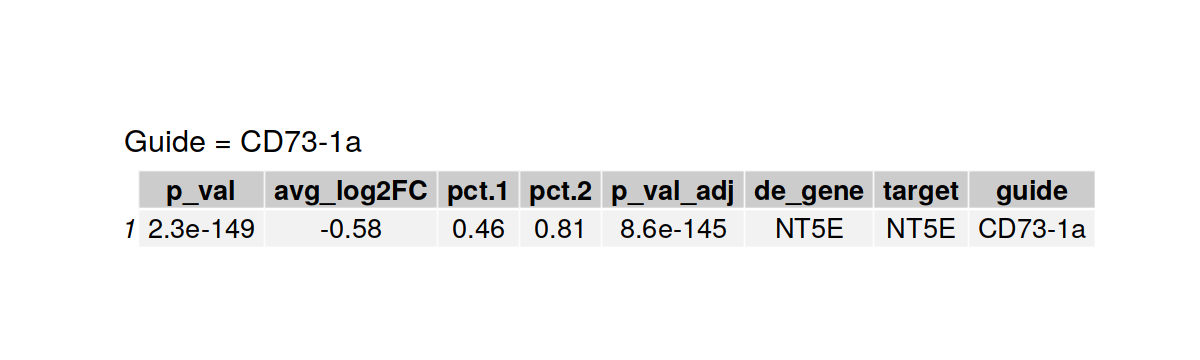

FTH1-1a 


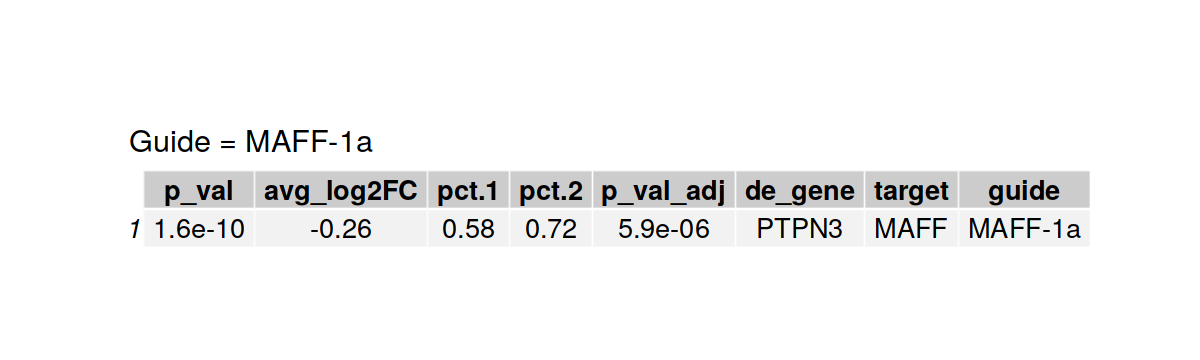

FTH1-2a 


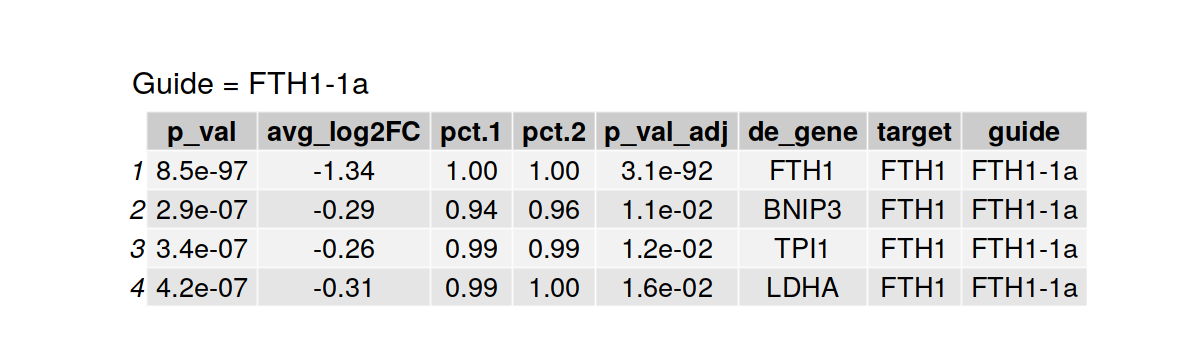

No diffex genes found. Skipping  PLIN3-1a 
PLIN3-2a 


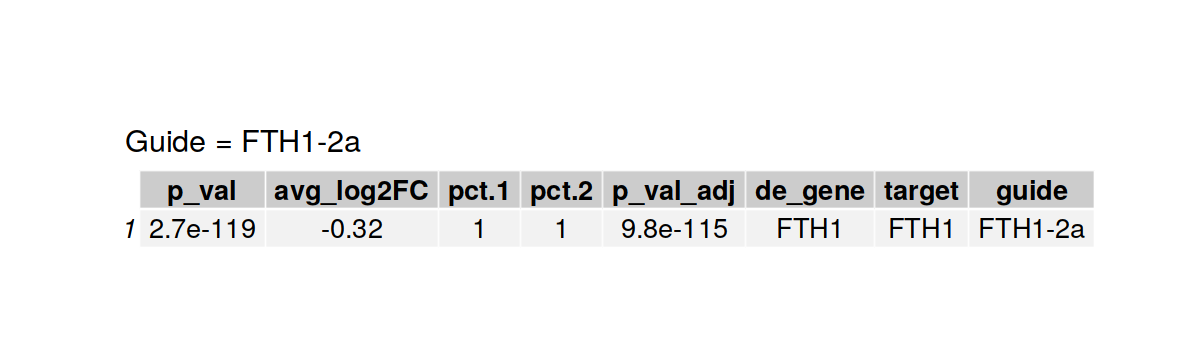

TKT-1a 


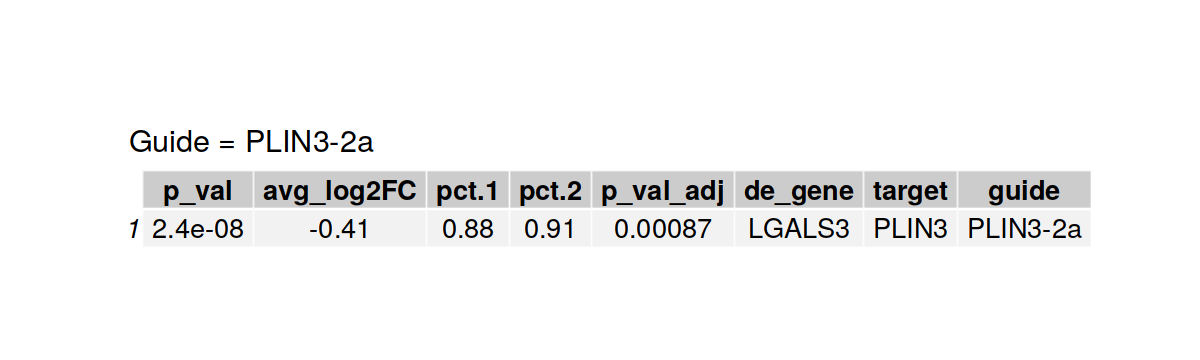

TKT-2a 


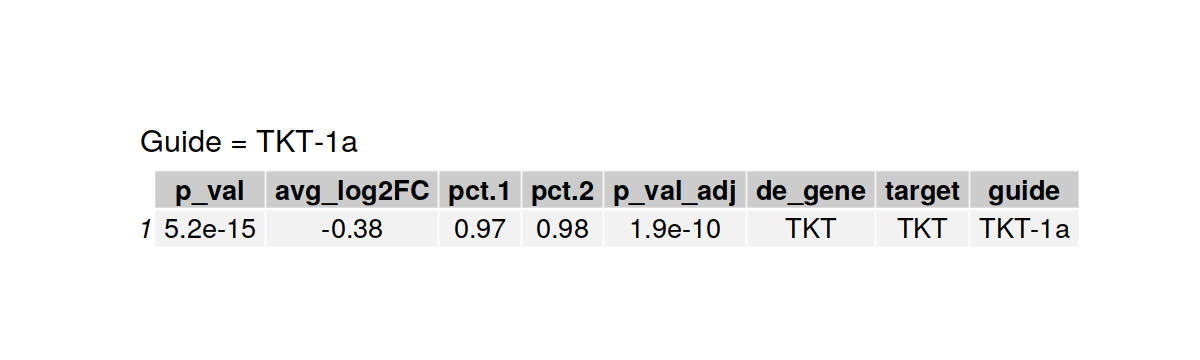

LGALS3-1a 


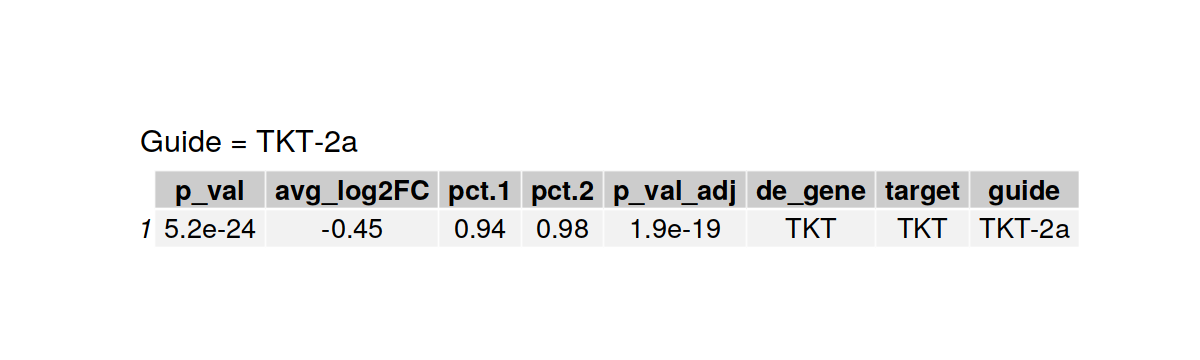

LGALS3-2a 


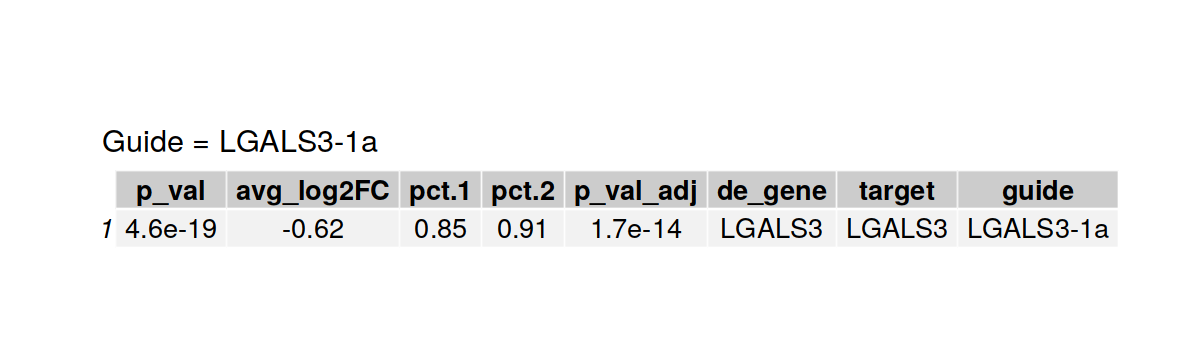

No diffex genes found. Skipping  CSTB-1a 
No diffex genes found. Skipping  CSTB-2a 
CTSB-1a 


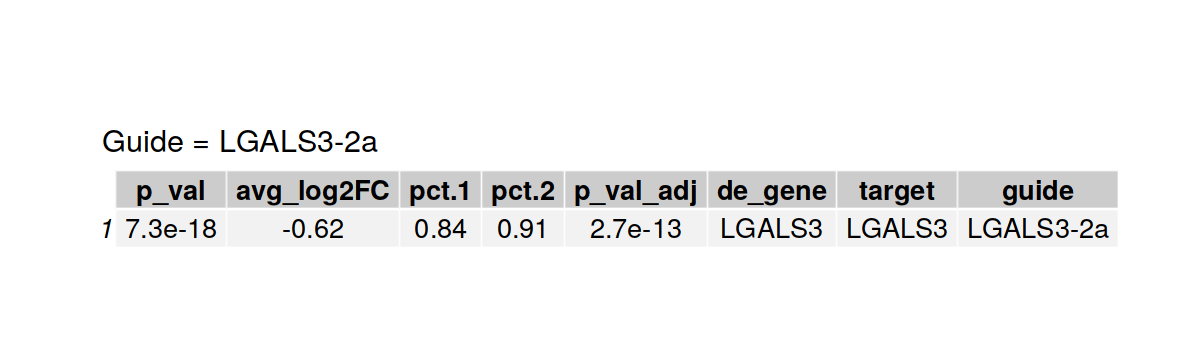

No diffex genes found. Skipping  CTSB-2a 
No diffex genes found. Skipping  KLF6-1a 
KLF6-2a 


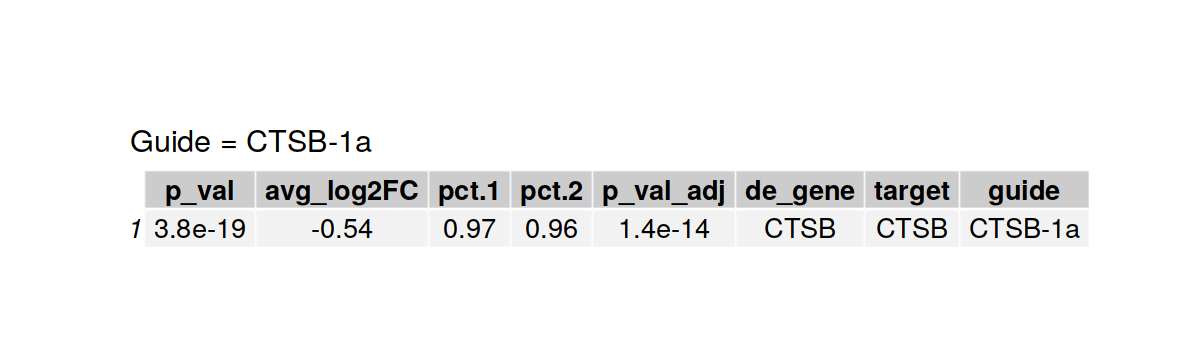

No diffex genes found. Skipping  DE1-1a 
No diffex genes found. Skipping  DE1-2a 
No cell found. Skipping  DE2-1a 
DE2-2a 


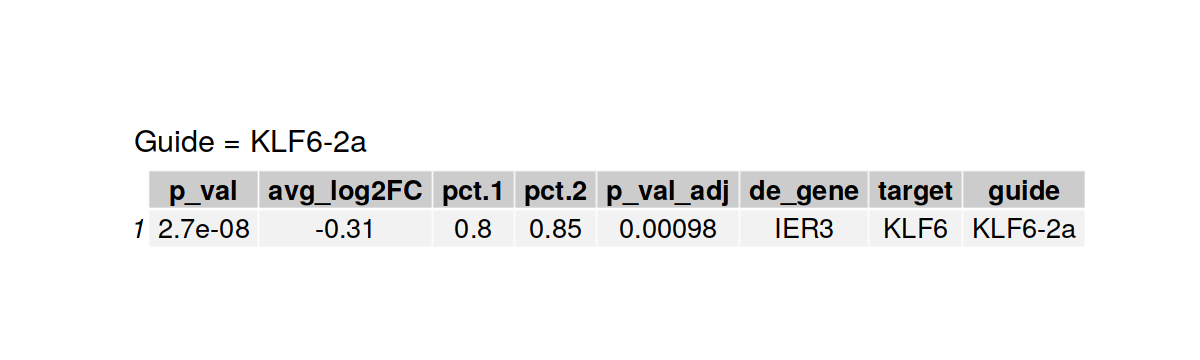

No diffex genes found. Skipping  DE3-1a 
No diffex genes found. Skipping  DE3-2a 
No diffex genes found. Skipping  DE4-1a 
No diffex genes found. Skipping  DE4-2a 
No diffex genes found. Skipping  DE5-1a 
No diffex genes found. Skipping  DE5-2a 
DE6-1a 


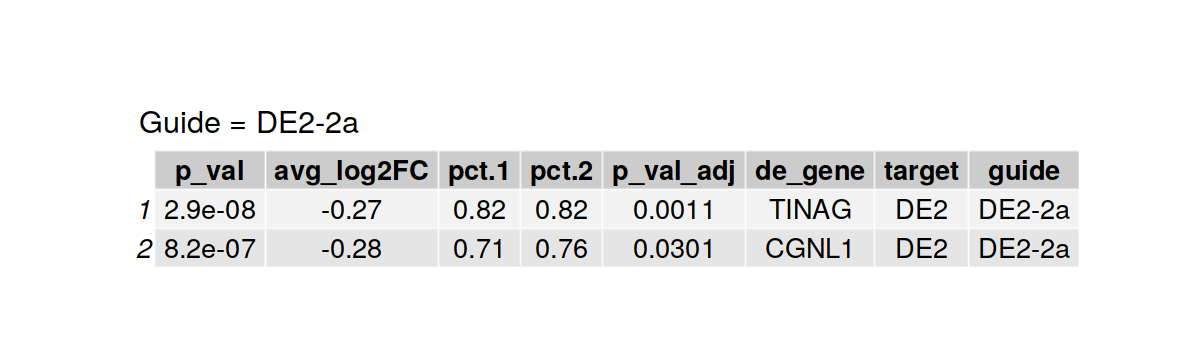

DE6-2a 


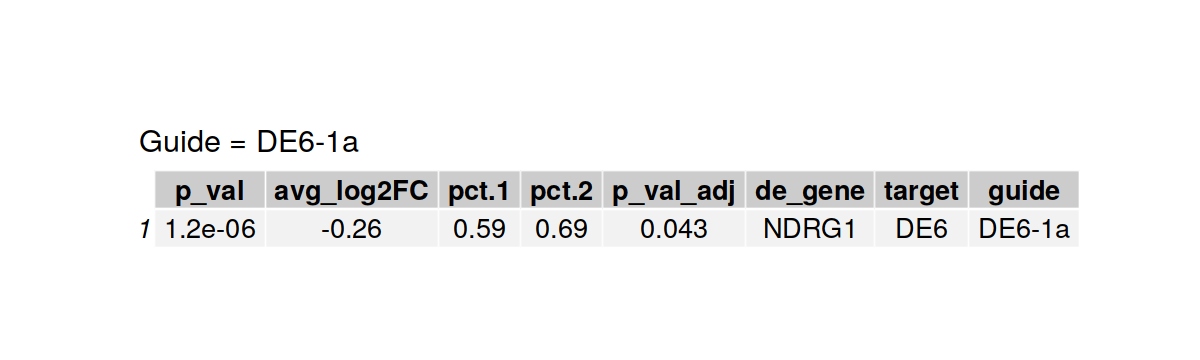

No diffex genes found. Skipping  DE7-1a 
No diffex genes found. Skipping  DE7-2a 
No diffex genes found. Skipping  DE8-1a 
No diffex genes found. Skipping  DE8-2a 
No diffex genes found. Skipping  DE9-1a 
No cell found. Skipping  DE9-2a 
DE10-1a 


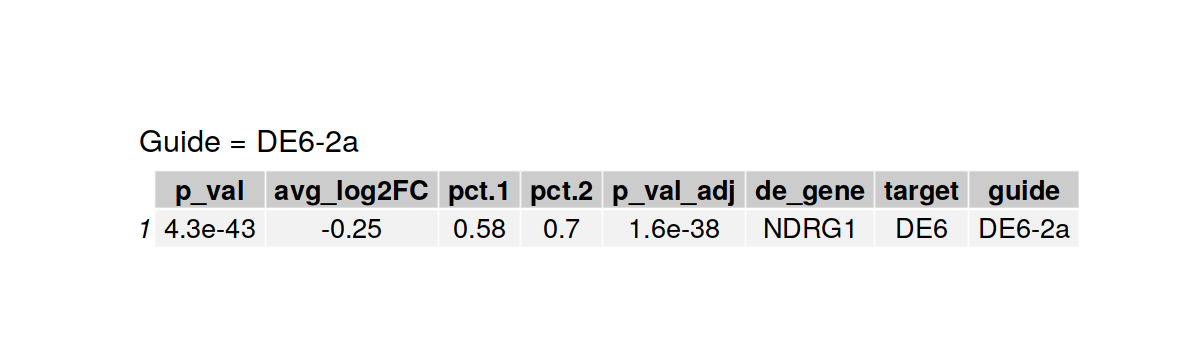

No diffex genes found. Skipping  DE10-2a 
No diffex genes found. Skipping  DE11-1a 
No diffex genes found. Skipping  DE11-2a 
No diffex genes found. Skipping  DE12-1a 
No diffex genes found. Skipping  DE12-2a 
No diffex genes found. Skipping  DE13-1a 
No diffex genes found. Skipping  DE13-2a 
No diffex genes found. Skipping  DE14-1a 
No diffex genes found. Skipping  DE14-2a 
DE15-1a 


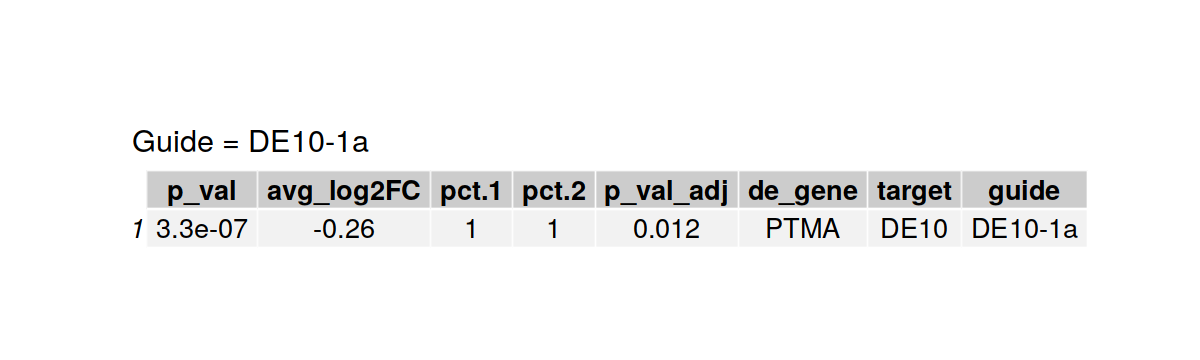

No diffex genes found. Skipping  DE15-2a 
No diffex genes found. Skipping  DE16-1a 
No cell found. Skipping  DE16-2a 
No diffex genes found. Skipping  DE17-1a 
No diffex genes found. Skipping  DE17-2a 
CD13-1b 


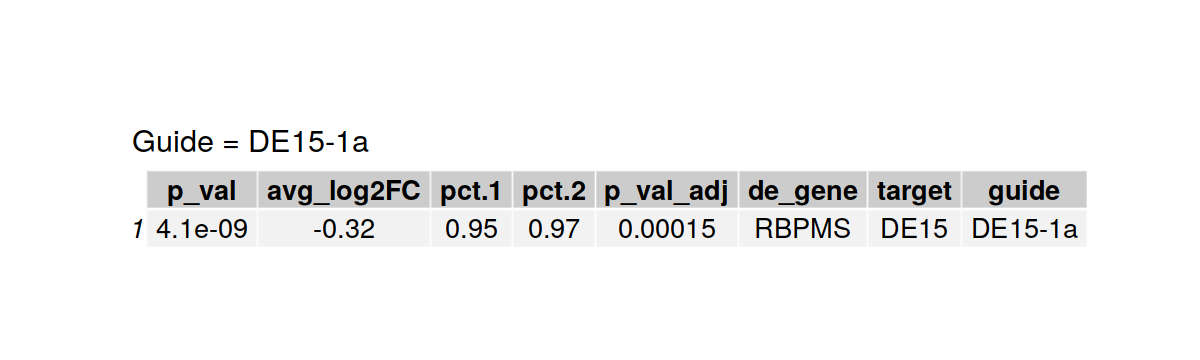

No diffex genes found. Skipping  CD55-1b 
No cell found. Skipping  CD-73-1b 
FUBP1-1b 


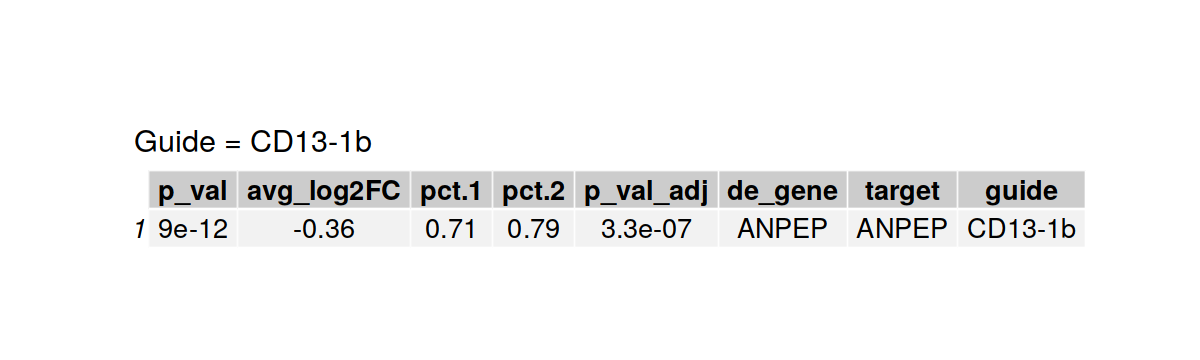

C15orf40-1b 


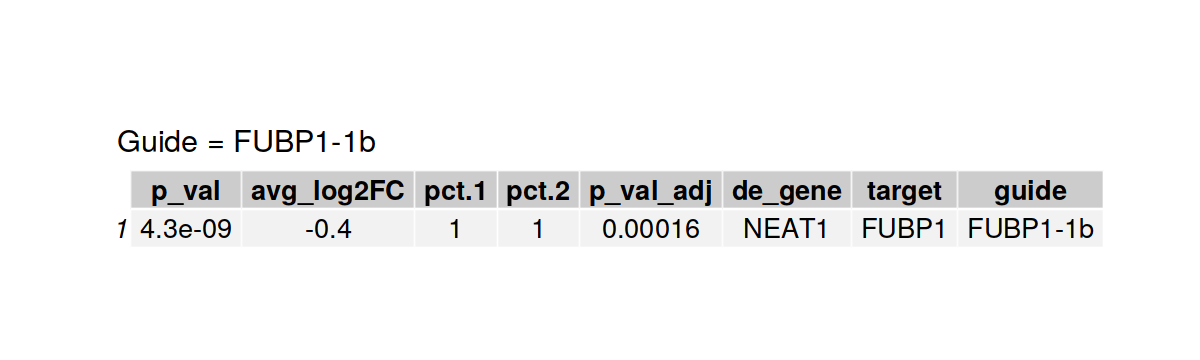

MAFF-1b 


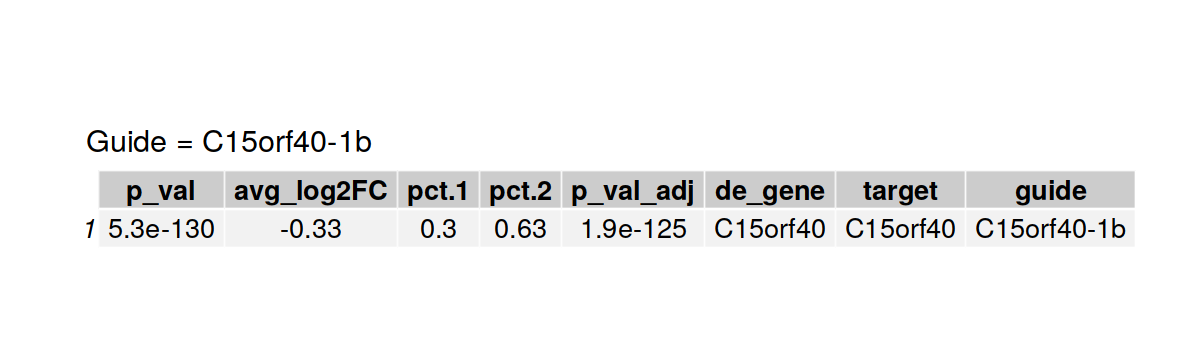

FTH1-1b 


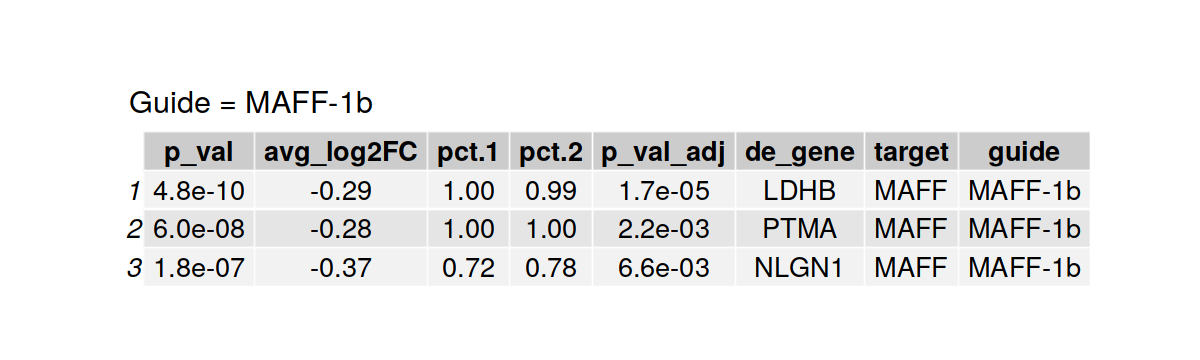

No cell found. Skipping  FTH1-2b 
PLIN3-1b 


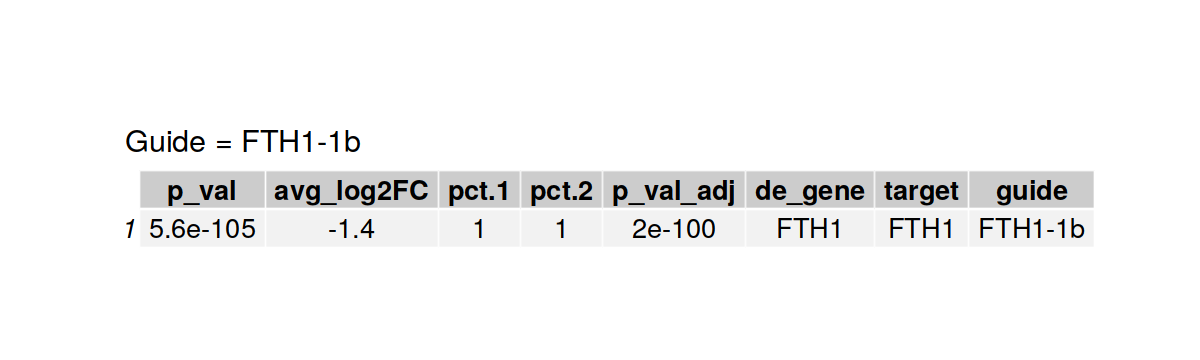

PLIN3-2b 


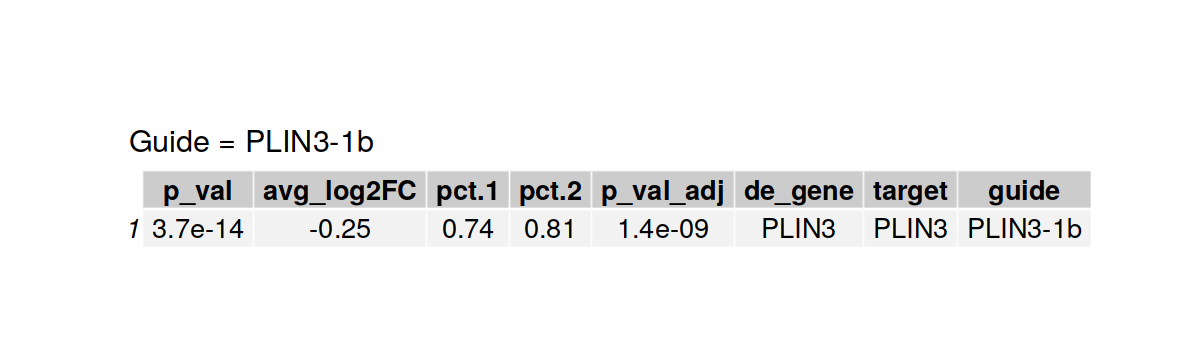

TKT-1b 


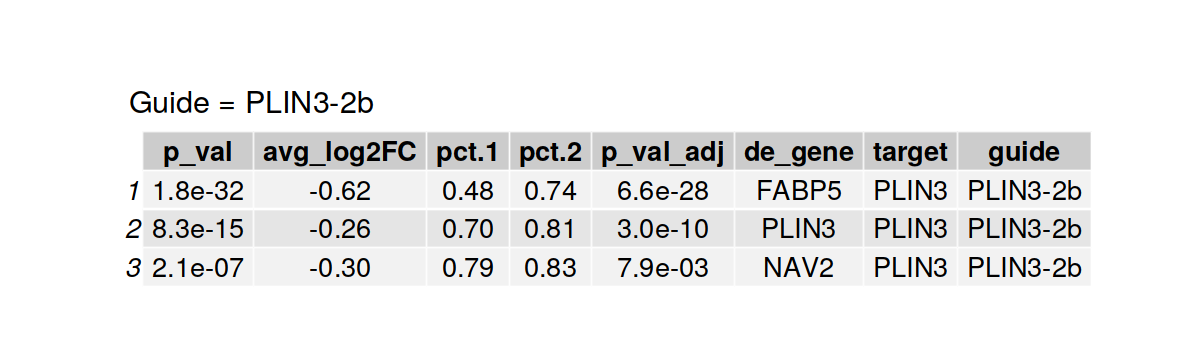

TKT-2b 


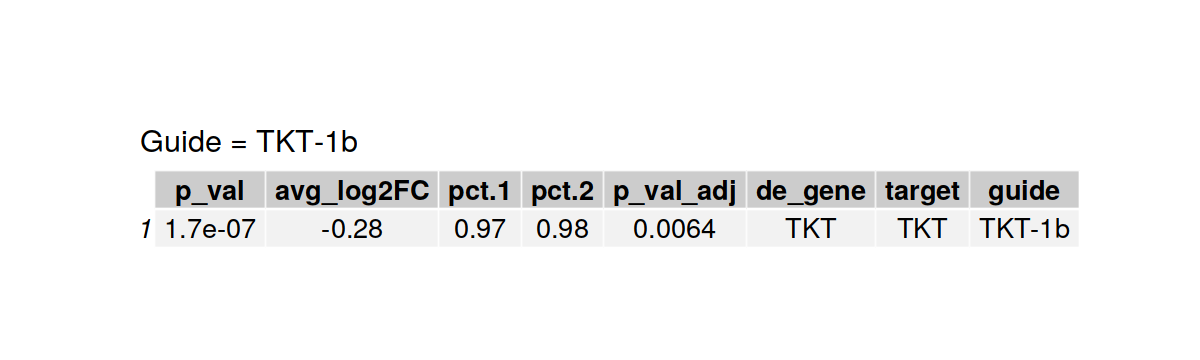

LGALS3-1b 


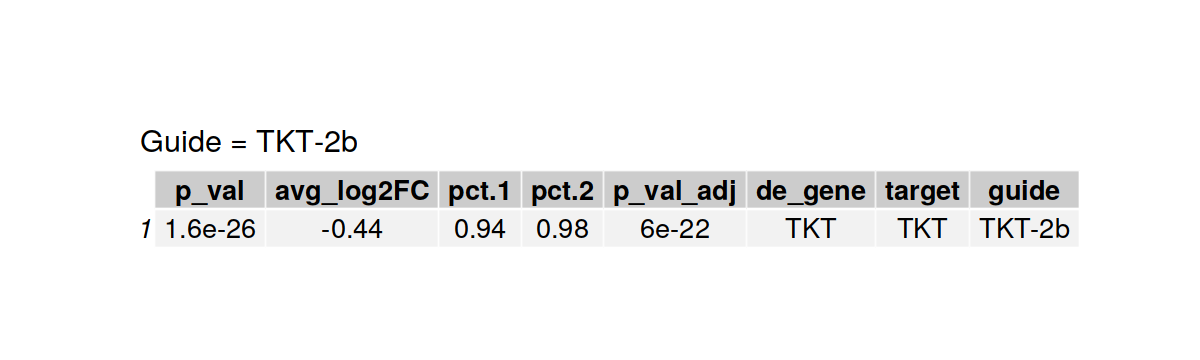

LGALS3-2b 


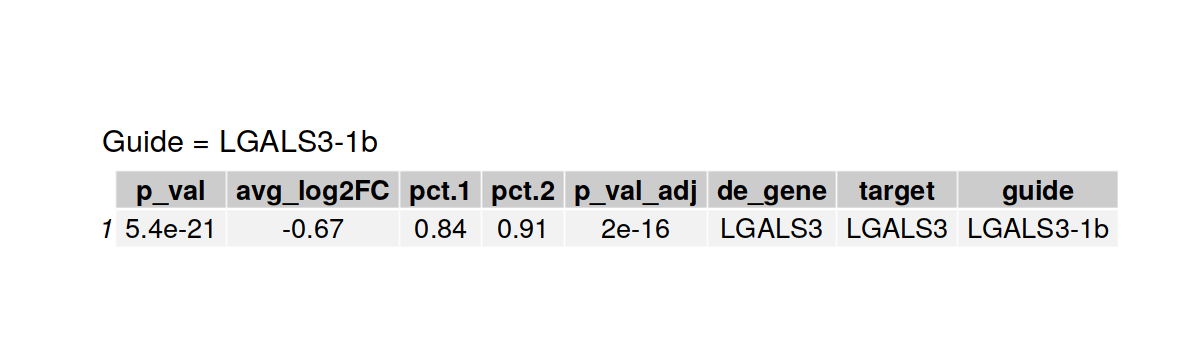

No diffex genes found. Skipping  CSTB-1b 
No diffex genes found. Skipping  CSTB-2b 
CTSB-1b 


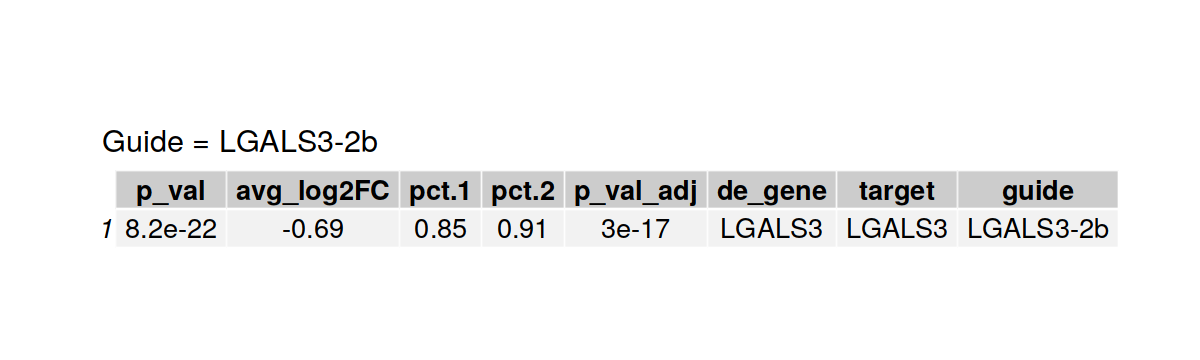

CTSB-2b 


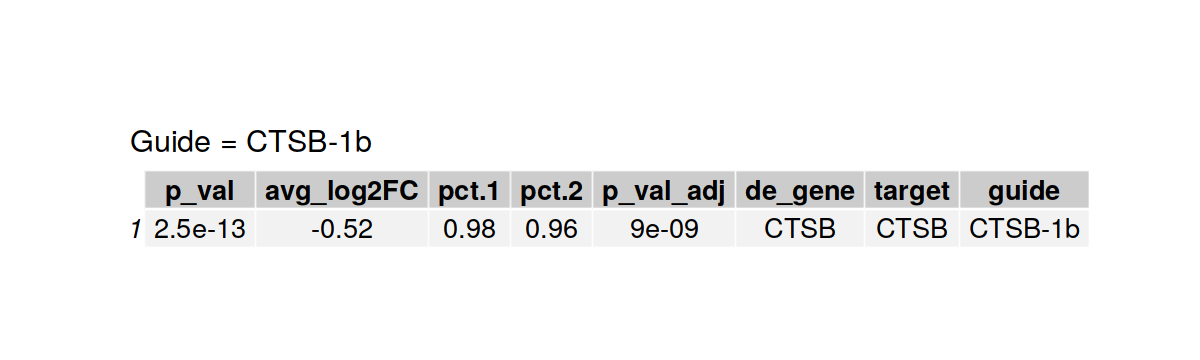

No diffex genes found. Skipping  KLF6-1b 
No diffex genes found. Skipping  KLF6-2b 
No diffex genes found. Skipping  DE1-1b 
No diffex genes found. Skipping  DE1-2b 
No cell found. Skipping  DE2-1b 
No diffex genes found. Skipping  DE2-2b 
No diffex genes found. Skipping  DE3-1b 
No diffex genes found. Skipping  DE3-2b 
No diffex genes found. Skipping  DE4-1b 
No diffex genes found. Skipping  DE4-2b 
No diffex genes found. Skipping  DE5-1b 
No diffex genes found. Skipping  DE5-2b 
No diffex genes found. Skipping  DE6-1b 
No diffex genes found. Skipping  DE6-2b 
No diffex genes found. Skipping  DE7-1b 
No diffex genes found. Skipping  DE7-2b 
No diffex genes found. Skipping  DE8-1b 
No diffex genes found. Skipping  DE8-2b 
No diffex genes found. Skipping  DE9-1b 
No cell found. Skipping  DE9-2b 
No diffex genes found. Skipping  DE10-1b 
No diffex genes found. Skipping  DE10-2b 
No diffex genes found. Skipping  DE11-1b 
No diffex genes found. Skipping  DE11-2b 
No diffex genes found. Ski

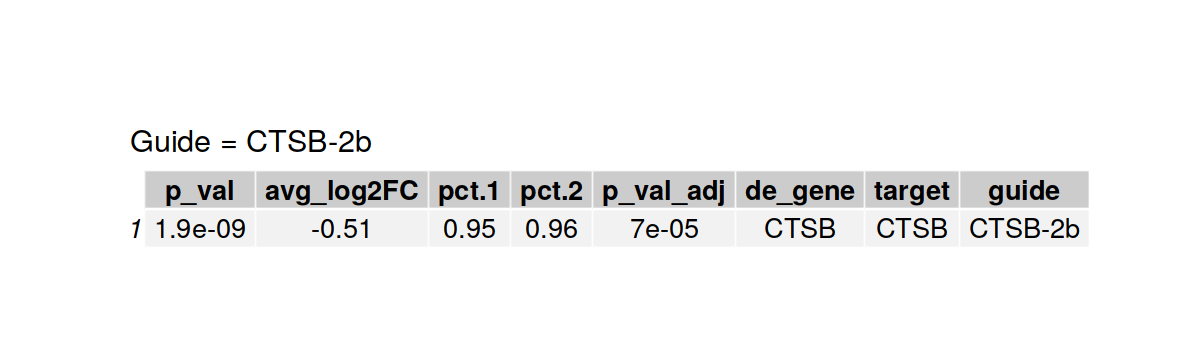

No diffex genes found. Skipping  DE16-1b 
No diffex genes found. Skipping  DE16-2b 
DE17-1b 


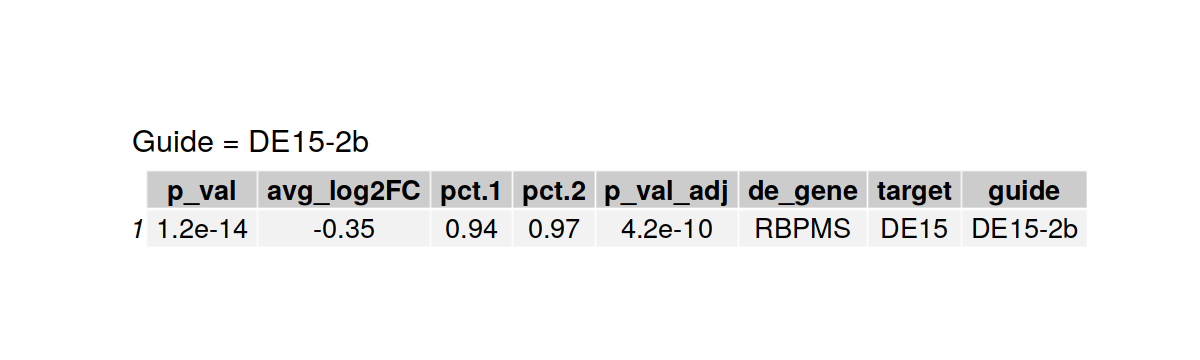

No diffex genes found. Skipping  DE17-2b 


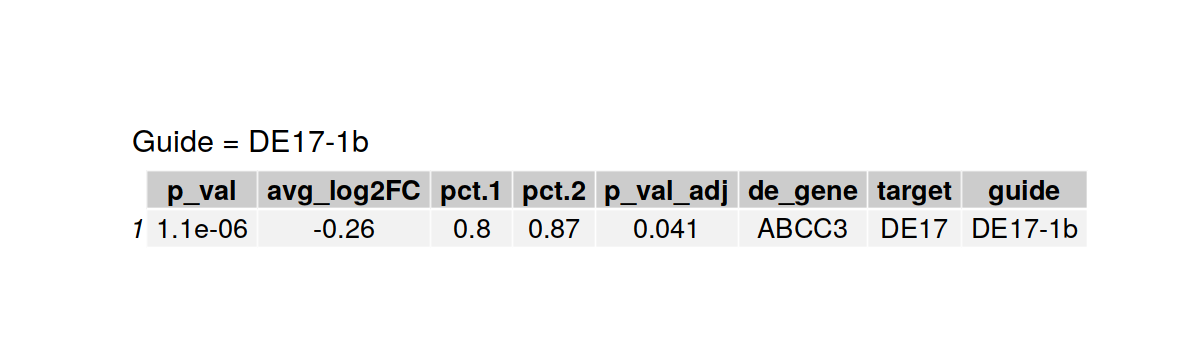

In [ ]:
library(huxtable)
options(repr.plot.width = 10, repr.plot.height = 3)
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)

for(guide_id in targeting_guides) {
    if(guide_id %in% guides_w_no_cells) {
        cat(green("No cell found. Skipping ", guide_id, "\n"))
    } else {
        df_dummy = df_de %>% filter(avg_log2FC < 0 & p_val_adj < 0.05) %>% filter(guide == guide_id) %>% arrange(p_val_adj)
        if(nrow(df_dummy > 0)) {            
            cat(green(guide_id, "\n"))
            title <- paste0("Guide = ", guide_id)
            tb <- ggtexttable(df_dummy, theme= ttheme(base_size = 16)) %>% tab_add_title(text = title, face = "plain", size = 18)
            print(tb)
        } else {
            cat(red("No diffex genes found. Skipping ", guide_id, "\n"))
        }
    }
}


In [ ]:
df_de %>% filter(guide == guide_id) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,guide
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
4.4e-06,-0.26,0.99,1.00,0.16,FXYD2,ANPEP,CD13-1a
2.2e-03,-0.27,0.69,0.62,1.00,S100A2,ANPEP,CD13-1a
2.3e-03,-0.28,0.92,0.95,1.00,SERPINA1,ANPEP,CD13-1a
7.6e-03,0.34,0.94,0.92,1.00,SMYD3,ANPEP,CD13-1a
8.2e-03,-0.33,0.25,0.26,1.00,ERBB4,ANPEP,CD13-1a
2.2e-02,-0.32,0.68,0.68,1.00,APOE,ANPEP,CD13-1a
2.8e-02,-0.28,0.47,0.49,1.00,KCNIP4,ANPEP,CD13-1a
5.5e-02,-0.33,0.54,0.50,1.00,MT1G,ANPEP,CD13-1a
6.0e-02,-0.31,0.70,0.71,1.00,MMP7,ANPEP,CD13-1a


In [ ]:
guides_w_no_cells

[1] "CD-73-1b"    "C150rf40-1a" "FTH1-2b"     "DE2-1a"      "DE2-1b"     
[6] "DE9-2a"      "DE9-2b"      "DE16-2a"

# -- Move this func into helpers.r

In [ ]:
vlnplot_for_guides <- function(seurat_obj, df_guide, perturbed_cells_by_guide, guides) {
    plt_list = list()
    for(i in seq_along(guides)) {
        guide = guides[i]
        print(guide)
        guides = get_guides_by_subclass(df_guide, 'alias', guide)
        seurat_dummy <- mark_guide_pos_target_neg(
            seurat_obj, 
            perturbed_cells_by_guide, 
            guide,
            guides, 
            print_counts = T
        )

        options(repr.plot.width=5, repr.plot.height=4)
        plt <- VlnPlot(
            object = seurat_dummy,
            features =  guide, 
            idents = NULL, 
            pt.size = 0., 
            sort = F, 
            ncol = 1,    
        ) + geom_boxplot(width=1, color="black", alpha=0.2) + theme(legend.position = 'none')  #+ stat_summary(fun = "mean", colour = "blue")
        plt_list[[i]] = plt
    }
    plt_list
}


## TSS controls

In [ ]:
plots = vlnplot_for_guides(seurat_rna, df_guide, perturbed_cells_by_guide, targeting_guides[1:6])
options(repr.plot.width=8, repr.plot.height=12)
ggarrange(plotlist=plots, ncol=3, nrow = 3)

[1] "CD13-1a"
Guide+ = 1055 SisterG+ = 0 ; Target- = 21363 ; All = 21363 


ERROR: Error in FetchData.Seurat(object = object, vars = features, slot = slot): None of the requested variables were found: CD13-1a


In [ ]:
guides = targeting_guides[1:6]

plt_list = list()
for(i in seq_along(guides)) {
    guide = guides[i]
    print(guide)
    guides = get_guides_by_subclass(df_guide, 'alias', guide)
    target = df_guide$
    seurat_dummy <- mark_guide_pos_target_neg(
        seurat_rna, 
        perturbed_cells_by_guide, 
        guide,
        guides, 
        print_counts = T
    )

    options(repr.plot.width=5, repr.plot.height=4)
    plt <- VlnPlot(
        object = seurat_dummy,        
        features = target,
        idents = c('guide_positive', "target_negative"), 
        pt.size = 0., 
        sort = F, 
        ncol = 1,    
    ) + geom_boxplot(width=1, color="black", alpha=0.2) + theme(legend.position = 'none')  #+ stat_summary(fun = "mean", colour = "blue")
    plt_list[[i]] = plt
}
plt_list


[1] "CD13-1a"
Guide+ = 1055 SisterG+ = 0 ; Target- = 21363 ; All = 21363 


ERROR: Error in ExIPlot(object = object, type = ifelse(test = split.plot, yes = "splitViolin", : argument "features" is missing, with no default
